# PCA as a treat?

Maybe instead of a dot product, we deserve a whole lil basis set. This notebook will be based on the data take in 25A bc I have some lab cals for them. Once I know this works I'm going to 

In [1]:
# ok so I gotta import these things to get things to work 
import os
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy import signal
from importlib import reload
import fixr
import lookyloo
from lookyloo.core import get_matching_paths
import datetime
import math

In [2]:
import spark_xrif as sx
import xrif_pull as xp

reload(xp)
reload(sx)

<module 'spark_xrif' from '/home/eden/code/testing/spark_xrif.py'>

### Setting myself up with some data

I want to do the xrif pull trick to get a lab stack and a data stack. I'm then going to try to make a PCA basis with the both of them. 

In [ ]:
# Dark directory
dark_dir = '/opt/MagAOX/calib/camwfs-dark/'

# feq 2000 EM gain ?
lab_dark = dark_dir + 'camwfs-dark_bin2_2000.000000_1.000000_-45.000000__T20250419020425366799769.fits'
# camwfs-dark_bin2_2000.000000_10.000000_-45.000000__T20251209235947719442977.fits
#freq 2000 EMGain 595
sky_dark = dark_dir + 'camwfs-dark_bin2_2000.000000_595.000000_-45.000000__T20250420001026277139922.fits'

In [4]:
# make sure to subtract the darks
dark_lab_data = fits.open(lab_dark)[0].data
dark_sky_data = fits.open(sky_dark)[0].data
wfs_mask = fits.open(xp.glob_dir_calib + xp.glob_mask)[0].data.astype(bool)

Looking at a dataset from 2025A - alfCen

In [5]:
######### OBS INFO
obs_plot_name = '2026 12-03 beta_pic '
sprk_type = '18, 22ld, 0.03 amp'
obs_name = 'piaa'

######### LAB INFO
lab_name = 'lab_efc'
# there are a lot of these, so this name is kinda degenerate

In [6]:
dt_start = datetime.datetime(2025, 11, 28, tzinfo=datetime.timezone.utc)
dt_end = datetime.datetime(2026, 1, 19, tzinfo=datetime.timezone.utc)
obs_idx = 8
#### The location to save it to
obs_save_file = 'spark_plts/' + obs_name + f'2026B_1201_betaPic_{obs_idx}'

obs_span_test = xp.verify_obs(obs_name, dt_start, n=obs_idx, dt_end=dt_end)

0. 	 LENGTH: 0:00:14.160118, 	 START: 2025-12-01 05:49:29.783734+00:00, 	 NAME: piaa 
1. 	 LENGTH: 2:18:26.751412, 	 START: 2025-12-01 05:49:48.576997+00:00, 	 NAME: piaa 
2. 	 LENGTH: 0:05:20.257120, 	 START: 2025-12-01 08:12:06.780803+00:00, 	 NAME: piaa_unsats 
3. 	 LENGTH: 0:00:00.113700, 	 START: 2025-12-01 08:17:32.567888+00:00, 	 NAME: piaa_unsats_nospark 
4. 	 LENGTH: 0:05:01.321941, 	 START: 2025-12-01 08:17:37.453976+00:00, 	 NAME: piaa_unsats_nospark 
5. 	 LENGTH: 0:09:55.456336, 	 START: 2025-12-01 08:24:56.853248+00:00, 	 NAME: piaa 
6. 	 LENGTH: 0:07:31.889952, 	 START: 2025-12-01 08:43:49.402299+00:00, 	 NAME: piaa_psfref 
7. 	 LENGTH: 0:32:52.358673, 	 START: 2025-12-01 08:56:07.120597+00:00, 	 NAME: piaa 
8. 	 LENGTH: 0:11:54.416477, 	 START: 2025-12-03 05:22:03.417450+00:00, 	 NAME: piaa 
9. 	 LENGTH: 0:00:36.704347, 	 START: 2025-12-03 05:34:08.247580+00:00, 	 NAME: piaa 
10. 	 LENGTH: 1:41:43.488952, 	 START: 2025-12-03 05:35:25.598608+00:00, 	 NAME: piaa 
11. 	 LEN

In [7]:
reload(xp)
file_list = xp.gen_file_list(obs_span_test, device='camwfs')
file_list

DATAPATH: /data/rawimages/camwfs


[TimestampedFile(path=PosixPath('/data/rawimages/camwfs/2025_12_03/camwfs_20251203052203614112000.xrif'), timestamp=datetime.datetime(2025, 12, 3, 5, 22, 3, 614112, tzinfo=datetime.timezone.utc)),
 TimestampedFile(path=PosixPath('/data/rawimages/camwfs/2025_12_03/camwfs_20251203052207710112000.xrif'), timestamp=datetime.datetime(2025, 12, 3, 5, 22, 7, 710112, tzinfo=datetime.timezone.utc)),
 TimestampedFile(path=PosixPath('/data/rawimages/camwfs/2025_12_03/camwfs_20251203052211806116000.xrif'), timestamp=datetime.datetime(2025, 12, 3, 5, 22, 11, 806116, tzinfo=datetime.timezone.utc)),
 TimestampedFile(path=PosixPath('/data/rawimages/camwfs/2025_12_03/camwfs_20251203052215902118000.xrif'), timestamp=datetime.datetime(2025, 12, 3, 5, 22, 15, 902118, tzinfo=datetime.timezone.utc)),
 TimestampedFile(path=PosixPath('/data/rawimages/camwfs/2025_12_03/camwfs_20251203052219998120000.xrif'), timestamp=datetime.datetime(2025, 12, 3, 5, 22, 19, 998120, tzinfo=datetime.timezone.utc)),
 Timestamped

In [8]:
# cleaning frames before using them
def clean_frames(data_cube, dark, mask):
    # Dark subtract 
    data_dark_sub = data_cube - dark
    # normalize in the mask 
    data_masked = data_dark_sub * mask
    # make friendly with a data stack
    data_normed = data_masked / np.sum(data_masked, axis=(1,2))[:,np.newaxis,np.newaxis]
    # then, we can do the mean subtraction
    data_subed = data_normed - np.mean(data_normed, axis=0)
    return data_subed 

In [12]:
len(file_list)*512

89600

### Pulling these files for usage

In [13]:
# the goal here is to pull some files and see if a PCA treatment works
data_test, timing_arr = xp.pull_n_files(file_list, 80000)

PULLING 80000 FILES
FILE no 157, n_start 0, n 80000, n_offset 0
XRIF index 0, no of files 157, len list 175
file n pull (80000, 120, 120)


In [14]:
# subtract means
data_clean = clean_frames(data_test, dark_sky_data, wfs_mask)

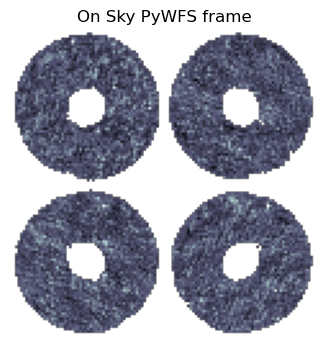

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
plt.title(f"On Sky PyWFS frame")
wfs_mask_nan = np.where(wfs_mask, wfs_mask, math.nan)
plt.imshow(data_clean[1]*wfs_mask_nan, cmap='bone')
plt.xticks([], [])
plt.yticks([], [])
plt.box(False)
plt.savefig("sky_pywfs_speck.pdf", dpi=300)

#### PCA on sky frames, not needed

In [25]:
# make into vectors, then 
K, x, y = data_clean.shape
N = x*y
image_shape = (x, y)

reference = data_clean.reshape(K, N)

E = np.cov(reference) * (N - 1)

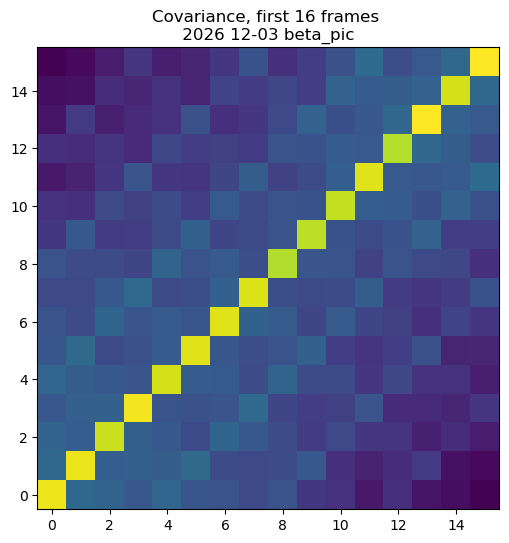

In [14]:
plt.figure(figsize=(6,6))
plt.title(f"Covariance, first 16 frames \n {obs_plot_name}")
plt.imshow(E[400:416, 400:416], origin='lower')

In [15]:
# now we want to see what we can about the eigenspace
lambda_values_out, C_out = np.linalg.eigh(E)
lambda_values = np.flip(lambda_values_out)
C = np.flip(C_out, axis=1)

(1000, 1000)

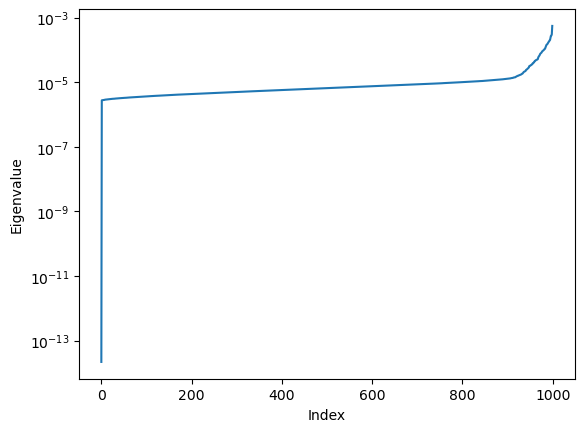

In [16]:
plt.plot(lambda_values_out)
plt.yscale('log')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
C_out.shape

In [17]:
# building a KL basis
Z_KL = reference.T @ (C * np.power(lambda_values, -1/2))

Text(0.5, 0.98, 'KL modes \n 2026 12-03 beta_pic ')

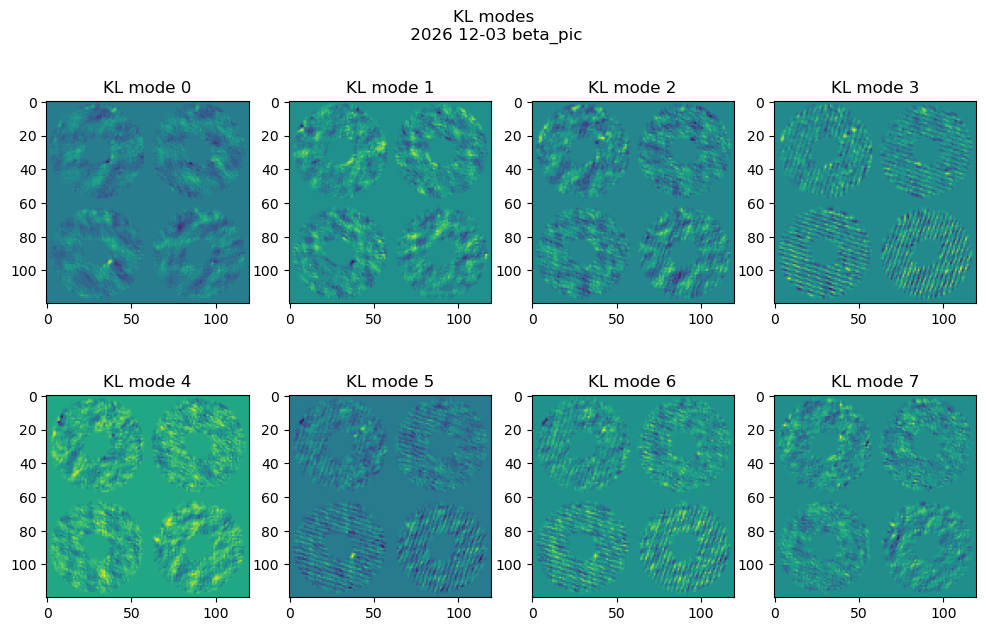

In [18]:
Z_KL_images = Z_KL.T.reshape((reference.shape[0],) + image_shape)
plt.figure(figsize=(12, 7))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.title(f"KL mode {i}")
    plt.imshow(Z_KL_images[i])
plt.suptitle(f"KL modes \n {obs_plot_name}")


In [ ]:
# next, we want to project one of the frames onto the basis to get a chance to 

## try again but with lab frames

In [15]:
dt_start = datetime.datetime(2025, 12, 1, tzinfo=datetime.timezone.utc)
dt_end = datetime.datetime(2026, 1, 19, tzinfo=datetime.timezone.utc)
obs_idx = 13

obs_span_test = xp.verify_obs(lab_name, dt_start, n=obs_idx, dt_end=dt_end)

0. 	 LENGTH: 0:01:00.473684, 	 START: 2025-12-01 00:15:56.441332+00:00, 	 NAME: lab_efc 
1. 	 LENGTH: 0:08:20.891551, 	 START: 2025-12-01 00:18:16.569681+00:00, 	 NAME: lab_efc_unsats 
2. 	 LENGTH: 0:06:59.773328, 	 START: 2025-12-01 00:31:58.671436+00:00, 	 NAME: lab_efc_unsats 
3. 	 LENGTH: 0:00:58.009527, 	 START: 2025-12-01 04:09:53.607342+00:00, 	 NAME: lab_efc_unsats 
4. 	 LENGTH: 0:01:56.055391, 	 START: 2025-12-01 04:13:54.830771+00:00, 	 NAME: lab_efc 
5. 	 LENGTH: 0:01:18.351099, 	 START: 2025-12-01 04:18:43.116268+00:00, 	 NAME: lab_efc 
6. 	 LENGTH: 0:00:59.102844, 	 START: 2025-12-01 05:33:19.435219+00:00, 	 NAME: lab_efc 
7. 	 LENGTH: 0:02:44.278920, 	 START: 2025-12-02 23:42:53.167064+00:00, 	 NAME: lab_efc 
8. 	 LENGTH: 0:03:12.246161, 	 START: 2025-12-02 23:48:09.109521+00:00, 	 NAME: lab_efc_unsats 
9. 	 LENGTH: 0:03:06.508568, 	 START: 2025-12-02 23:52:48.130830+00:00, 	 NAME: lab_efc_unsats_dark 
10. 	 LENGTH: 0:02:23.796118, 	 START: 2025-12-02 23:56:31.631120+00:0

In [16]:
file_list = xp.gen_file_list(obs_span_test, device='camwfs')
file_list

DATAPATH: /data/rawimages/camwfs


[TimestampedFile(path=PosixPath('/data/rawimages/camwfs/2025_12_03/camwfs_20251203042138652520000.xrif'), timestamp=datetime.datetime(2025, 12, 3, 4, 21, 38, 652520, tzinfo=datetime.timezone.utc)),
 TimestampedFile(path=PosixPath('/data/rawimages/camwfs/2025_12_03/camwfs_20251203042142748522000.xrif'), timestamp=datetime.datetime(2025, 12, 3, 4, 21, 42, 748522, tzinfo=datetime.timezone.utc)),
 TimestampedFile(path=PosixPath('/data/rawimages/camwfs/2025_12_03/camwfs_20251203042146844524000.xrif'), timestamp=datetime.datetime(2025, 12, 3, 4, 21, 46, 844524, tzinfo=datetime.timezone.utc)),
 TimestampedFile(path=PosixPath('/data/rawimages/camwfs/2025_12_03/camwfs_20251203042150940526000.xrif'), timestamp=datetime.datetime(2025, 12, 3, 4, 21, 50, 940526, tzinfo=datetime.timezone.utc)),
 TimestampedFile(path=PosixPath('/data/rawimages/camwfs/2025_12_03/camwfs_20251203042155036527000.xrif'), timestamp=datetime.datetime(2025, 12, 3, 4, 21, 55, 36527, tzinfo=datetime.timezone.utc)),
 Timestampe

In [17]:
data_test_lab, timing_arr = xp.pull_n_files(file_list, 1000)

PULLING 1000 FILES
FILE no 2, n_start 0, n 1000, n_offset 0
XRIF index 0, no of files 2, len list 12
file n pull (1000, 120, 120)


In [18]:
# subtract means
data_clean_lab = clean_frames(data_test_lab, dark_sky_data, wfs_mask)

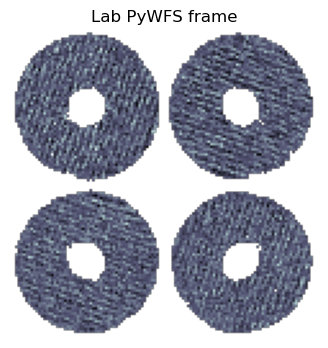

In [22]:
#plt.title(f"Darksub, lab, meansub \n {obs_plot_name} {lab_name}")

fig, ax = plt.subplots(figsize=(4,4))
plt.title(f"Lab PyWFS frame")
wfs_mask_nan = np.where(wfs_mask, wfs_mask, math.nan)
plt.imshow(data_clean_lab[1]*wfs_mask_nan, cmap='bone')
plt.xticks([], [])
plt.yticks([], [])
plt.box(False)
plt.show()
#plt.savefig("lab_pywfs_speck.pdf", dpi=300)

In [19]:
# make into vectors, then 
K, x, y = data_clean_lab.shape
N = x*y
image_shape = (x, y)

reference_lab = data_clean_lab.reshape(K, N)

E = np.cov(reference_lab) * (N - 1)

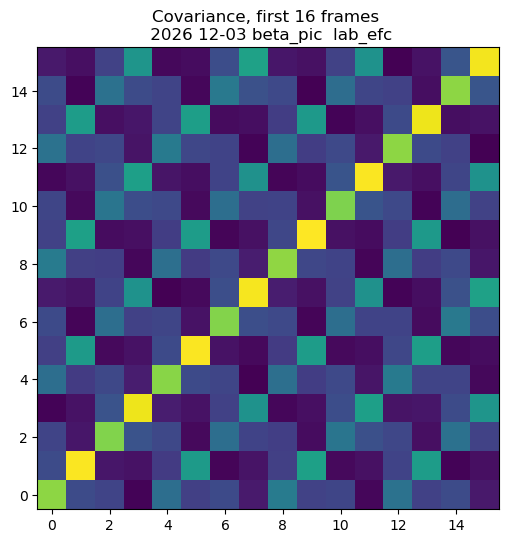

In [24]:
plt.figure(figsize=(6,6))
plt.title(f"Covariance, first 16 frames \n {obs_plot_name} {lab_name}")
plt.imshow(E[400:416, 400:416], origin='lower')

In [20]:
# now we want to see what we can about the eigenspace
lambda_values_out, C_out = np.linalg.eigh(E)
lambda_values = np.flip(lambda_values_out)
C = np.flip(C_out, axis=1)

(1000, 1000)

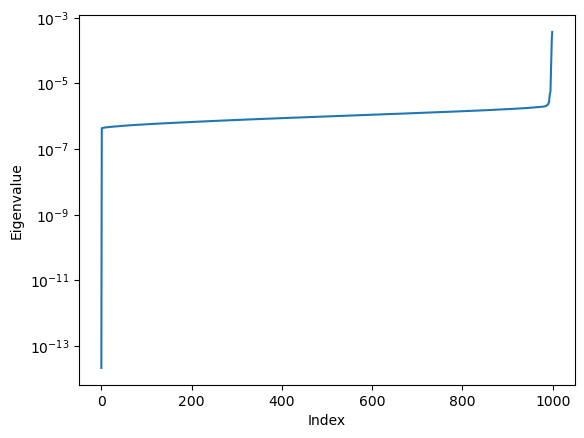

In [26]:
plt.plot(lambda_values_out)
plt.yscale('log')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
C_out.shape

In [21]:
# building a KL basis
Z_KL_lab = reference_lab.T @ (C * np.power(lambda_values, -1/2))

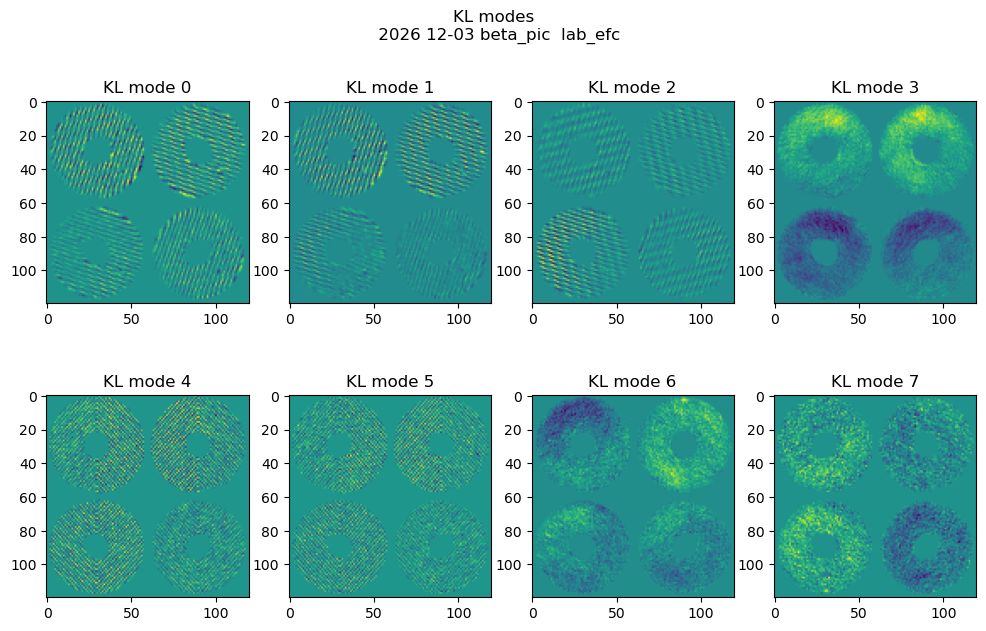

In [28]:
Z_KL_lab_images = Z_KL_lab.T.reshape((reference_lab.shape[0],) + image_shape)
plt.figure(figsize=(12, 7))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.title(f"KL mode {i}")
    plt.imshow(Z_KL_lab_images[i])
plt.suptitle(f"KL modes \n {obs_plot_name} {lab_name}")
plt.show()

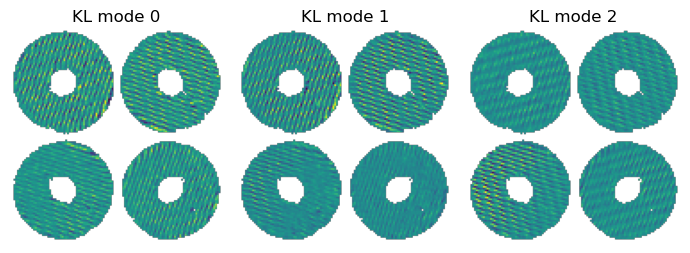

In [29]:
Z_KL_lab_images = Z_KL_lab.T.reshape((reference_lab.shape[0],) + image_shape)
plt.figure(figsize=(7, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"KL mode {i}")
    plt.imshow(Z_KL_lab_images[i]*wfs_mask_nan)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.box(False)
#plt.suptitle(f"KL modes \n {obs_plot_name} {lab_name}")
plt.tight_layout()
plt.show()

In [22]:
klip = 3
Z_KL_lab_truc = Z_KL_lab[:,:klip]

In [23]:
Z_KL_lab_truc.T @ Z_KL_lab_truc # as expected , the diagonal is 1 ... 

array([[ 1.00000000e+00,  1.12458870e-16, -1.98463208e-16],
       [ 1.12458870e-16,  1.00000000e+00, -1.71629204e-16],
       [-1.98463208e-16, -1.71629204e-16,  1.00000000e+00]])

In [26]:
Ihat_psi0 = Z_KL_lab_truc @ (Z_KL_lab_truc.T @ reference[0])

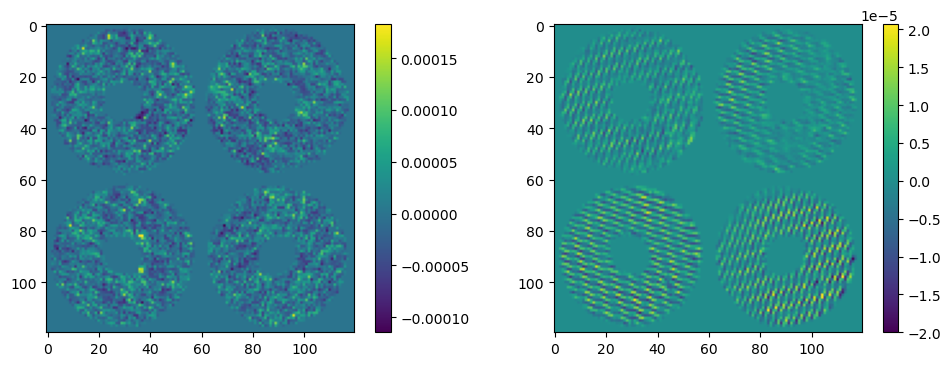

In [27]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(reference[0].reshape(image_shape))
plt.colorbar()
plt.subplot(122)
plt.imshow(Ihat_psi0.reshape(image_shape))
plt.colorbar()

### project on lab vs. project on sky

In [28]:
example_proj_lab = np.array([Z_KL_lab_truc.T @ ref for ref in reference_lab[:100]])

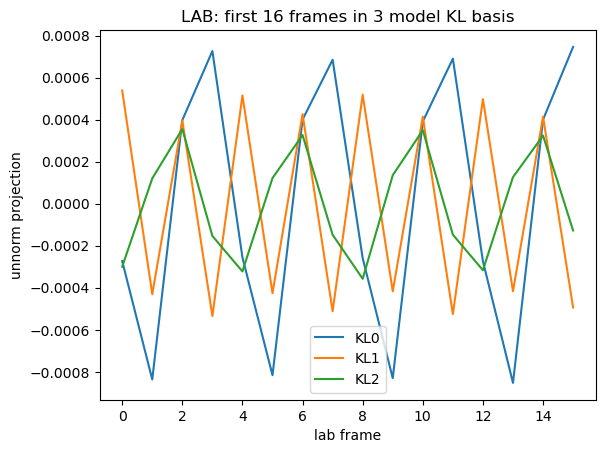

In [35]:
plt.title("LAB: first 16 frames in 3 model KL basis")
for i in range(3):
    plt.plot(example_proj_lab[:16,i], label=f"KL{i}")
plt.xlabel("lab frame")
plt.ylabel("unnorm projection")
plt.legend()
plt.show()

In [29]:
# I deleted something, so annoying,,,, 
def split_data_avg(lab_cube):
    arr_s1 = np.mean(lab_cube[::4,:], axis=0)
    arr_s2 = np.mean(lab_cube[1::4,:], axis=0)
    arr_s3 = np.mean(lab_cube[2::4,:], axis=0)
    arr_s4 = np.mean(lab_cube[3::4,:], axis=0)
    return arr_s1, arr_s2, arr_s3, arr_s4


In [30]:
lab_avgs = split_data_avg(example_proj_lab)
lab_avgs_roll = np.roll(lab_avgs,-2, axis=0)

In [31]:
lab_avgs

(array([-0.00030102,  0.00049326, -0.00039568]),
 array([-0.0007399 , -0.00047751,  0.000171  ]),
 array([0.00032122, 0.00049482, 0.00037912]),
 array([ 0.00072311, -0.00050607, -0.00015896]))

In [32]:
lab_avgs_roll

array([[ 0.00032122,  0.00049482,  0.00037912],
       [ 0.00072311, -0.00050607, -0.00015896],
       [-0.00030102,  0.00049326, -0.00039568],
       [-0.0007399 , -0.00047751,  0.000171  ]])

### SKY 

In [45]:
example_proj = np.array([Z_KL_lab_truc.T @ ref for ref in reference])

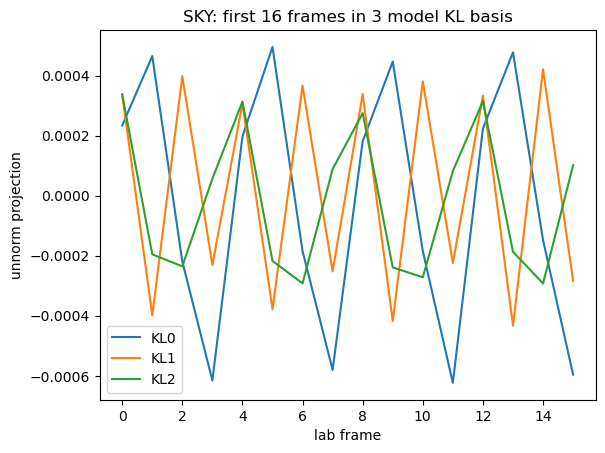

In [34]:
plt.title("SKY: first 16 frames in 3 model KL basis")
for i in range(3):
    plt.plot(example_proj[:16,i], label=f"KL{i}")
plt.xlabel("lab frame")
plt.ylabel("unnorm projection")
plt.legend()
plt.show()

In [35]:
# Jared's suggestion: check the RMS of each segment

rms_lab = np.std(example_proj_lab, axis=0)
rms_sky = np.std(example_proj, axis=0)

og_rms = rms_sky/rms_lab


In [60]:
filepath = "/opt/MagAOX/cacao/tweeter-vispyr/tweeter-vispyr-calibs/"
selfRM_name_lab = "selfRM_lab_20251127_amp02.fits"
selfRM_name_sky = "selfRM_sky_20251202_betaPic_2220_amp03.fits"

lab_data = np.diag(fits.open(filepath + selfRM_name_lab)[0].data[5])
sky_data = np.diag(fits.open(filepath + selfRM_name_sky)[0].data[5])

og_data = sky_data/lab_data
og_selfrm = np.mean(og_data)


In [113]:
np.repeat(lab_avgs_roll[:,i].reshape(1,4), 250, axis=0).flatten()

array([ 0.00016244,  0.00039021, -0.00016653, -0.00038932,  0.00016244,
        0.00039021, -0.00016653, -0.00038932,  0.00016244,  0.00039021,
       -0.00016653, -0.00038932,  0.00016244,  0.00039021, -0.00016653,
       -0.00038932,  0.00016244,  0.00039021, -0.00016653, -0.00038932,
        0.00016244,  0.00039021, -0.00016653, -0.00038932,  0.00016244,
        0.00039021, -0.00016653, -0.00038932,  0.00016244,  0.00039021,
       -0.00016653, -0.00038932,  0.00016244,  0.00039021, -0.00016653,
       -0.00038932,  0.00016244,  0.00039021, -0.00016653, -0.00038932,
        0.00016244,  0.00039021, -0.00016653, -0.00038932,  0.00016244,
        0.00039021, -0.00016653, -0.00038932,  0.00016244,  0.00039021,
       -0.00016653, -0.00038932,  0.00016244,  0.00039021, -0.00016653,
       -0.00038932,  0.00016244,  0.00039021, -0.00016653, -0.00038932,
        0.00016244,  0.00039021, -0.00016653, -0.00038932,  0.00016244,
        0.00039021, -0.00016653, -0.00038932,  0.00016244,  0.00

In [44]:
example_proj.shape

(1000, 3)

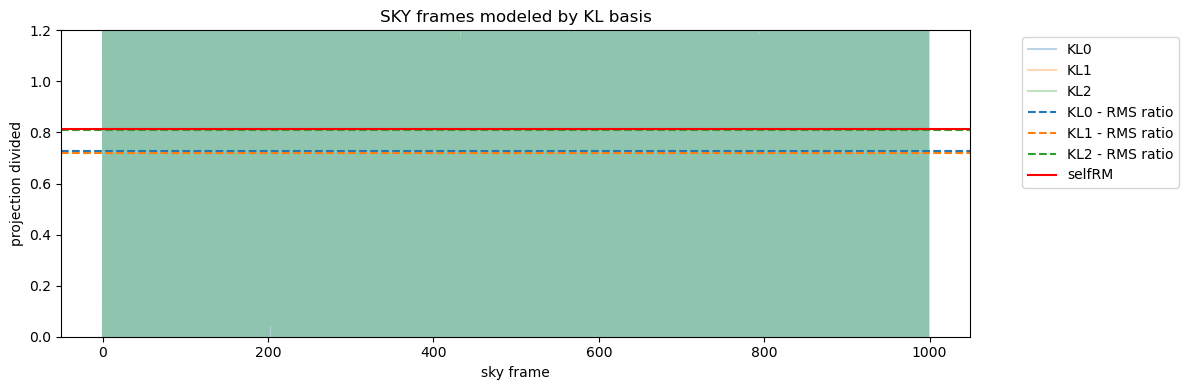

In [37]:
fig = plt.figure(figsize=(12, 4))

plt.title("SKY frames modeled by KL basis")

lab_avgs_roll = np.roll(lab_avgs, -1, axis=0)

for i in range(3):
    # TODO: make 250 not hardcoded
    divisor = np.repeat(lab_avgs_roll[:,i].reshape(1,4), 250, axis=0).flatten()
    plt.plot(example_proj[:,i]/divisor, label=f"KL{i}", alpha=0.3)

for i in range(3):
    plt.axhline(og_rms[i], label=f"KL{i} - RMS ratio", linestyle='--', color=f"C{i}")

plt.ylim(0, 1.2)
plt.axhline(og_selfrm, c="red", label="selfRM")
plt.xlabel("sky frame")
plt.ylabel("projection divided")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [47]:
# calculate the OG for each of these:
lab_avgs_roll = np.roll(lab_avgs, -1, axis=0)

OG_arrays = []
for i in range(3):
    divisor = np.repeat(lab_avgs_roll[:,i].reshape(1,4), 250*80, axis=0).flatten()
    og_temp = example_proj[:,i]/divisor
    OG_arrays.append(og_temp)


In [39]:
# rolling calculations
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def moving_stdv(a, n=3):
    ret = np.array([np.std(a[i:i+n]) for i in np.arange(len(a-n))])
    return ret[:-n+1]

def return_rolling(dot_mat, n=100):
    dot_avgs = moving_average(dot_mat, n=n)
    dot_stds = moving_stdv(dot_mat, n=n)
    return dot_avgs, dot_stds

In [48]:
# do this again but with a 10 frame rolling average?

og_rolling = [return_rolling(OG_array) for OG_array in OG_arrays]

In [63]:
len(og_rolling[0][0])

79901

In [ ]:
t_shift  = X_shift / 2000

array([   50,    51,    52, ..., 79948, 79949, 79950], shape=(79901,))

In [ ]:
X_shift = np.arange(50, len(og_rolling[0][0])+50)
t_shift  = X_shift / 2000

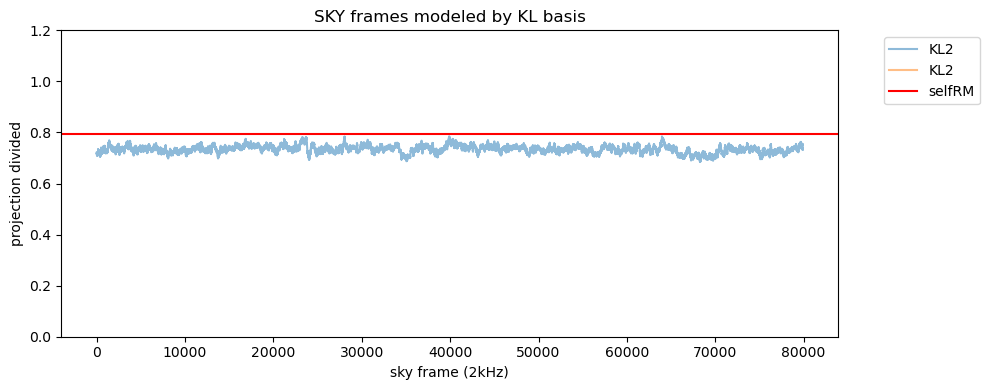

In [ ]:
fig = plt.figure(figsize=(10, 4))
plt.title("SKY frames modeled by KL basis")

for og_r in og_rolling[:2]:
    plt.plot(t_shift, og_r[0], label=f"KL{i}", alpha=0.7)
    plt.fill_between(t_shift, og_r[0] - og_r[1], og_r[0] + og_r[1], alpha = 0.2)

#for i in range(3):
#    plt.axhline(og_rms[i], label=f"KL{i} - RMS ratio", linestyle='--', color=f"C{i}")

plt.ylim(0, 1.2)
plt.axhline(og_selfrm, c="red", label="selfRM")
plt.xlabel("sky frame (2kHz)")
plt.ylabel("projection divided")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### pretty pictures

In [ ]:
# pretty plot of the two different self RMs
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(4,4))

plt.title("Lab selfRM")
img1 = ax.imshow(fits.open(filepath + selfRM_name_lab)[0].data[5][:100, :100], origin='lower', cmap='plasma')
plt.xlabel("mode number")
plt.ylabel("mode response")

divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img1, cax=cax1)

plt.savefig("lab_selfRM_demo.pdf", dpi=300)